# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from keras.models import Sequential
# from keras.layers import Dense
# from keras import regularizers
# from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import gym

from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3.common.vec_env import DummyVecEnv

# Functions

In [2]:
def grid_search_classifier(function, param_grid, cv = 10):
    # Running Grid Search
    grid_search = GridSearchCV(function, param_grid, cv = cv)
    grid_search.fit(x_train, y_train)
    
    # Outputting results
    print(f'Best parameters are: {grid_search.best_params_}\n')
    print(f'Accuracy is: {grid_search.score(x_test, y_test)}\n')
    try:
        print(f'AUC score is: {roc_auc_score(y_test, grid_search.predict_proba(x_test)[:, 1])}\n')
    except:
        pass
    best_model = grid_search.best_estimator_
    pred_rf = best_model.predict(x_test)
    print(f'Classification report:\n {classification_report(y_test, pred_rf, target_names = ["Lower Ranked", "Higher Ranked"])}')
    print(f'MCC is: {matthews_corrcoef(y_test, pred_rf)}')
    
    return best_model

# Data work

In [3]:
data = pd.read_csv('mma_data.csv', index_col=0)

# Filtering out unwanted rows
data = data[data.result >= 0]
data = data[data.slpm_2 + data.sapm_2 != 0]
data = data[data.slpm_1 + data.sapm_1 != 0]

In [4]:
# Engineering some columns
data['reach_diff'] = data.reach_1 - data.reach_2
data['age_diff'] = data.age_1 - data.age_2
data['slpm_diff'] = data.slpm_1 - data.slpm_2
data['sapm_diff'] = data.sapm_1 - data.sapm_2
data['td_acc_diff'] = data.td_acc_1 - data.td_acc_2
data['td_def_diff'] = data.td_def_1 - data.td_def_2
data['td_avg_diff'] = data.td_avg_1 - data.td_avg_2
data['sub_avg_diff'] = data.sub_avg_1 - data.sub_avg_2
data['strk_acc_diff'] = data.strk_acc_1 - data.strk_acc_2
data['strk_def_diff'] = data.strk_def_1 - data.strk_def_2
data['wins_diff'] = data.wins_1 - data.wins_2
data['losses_diff'] = data.losses_1 - data.losses_2
data['win_pct_1'] = data.wins_1/(data.losses_1 + data.wins_1)
data['win_pct_2'] = data.wins_2/(data.losses_2 + data.wins_2)
data['win_pct_diff'] = data.win_pct_1 - data.win_pct_2

# Getting a dataset for only veteran fights
data_v2 = data.copy()

# Droping unecessary columnns and scaling data
data.drop(['fighter_1', 'fighter_2'], axis = 1, inplace = True)
x_cols = ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1', 'age_1']
y_col = ['result']
x, y = data[x_cols], data[y_col]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

# Formatting data
x_train = x_train.values
y_train = y_train.values.ravel()
x_test = x_test.values
y_test = y_test.values.ravel()

# Predicting Winner

### Setting Baseline

In [6]:
print(f'Predicting fighter 1 would yield {data.result.mean()*100}% accuracy')

df = data.copy()
df['Higher_Pct'] = df.win_pct_diff.apply(lambda x: 1 if x > 0 else 0)
df['Result_Tracker'] = df.apply(lambda x: 1 if (x.Higher_Pct == 1) & (x.result == 1)
                               else 1 if (x.Higher_Pct == 0) & (x.result == 0)
                               else 0, axis = 1)
print(f'Predicting the fighter with the higher win percentage would yield {df.Result_Tracker.mean()*100}% accuracy')

Predicting fighter 1 would yield 56.99999999999999% accuracy
Predicting the fighter with the higher win percentage would yield 56.8% accuracy


### Neural Network

In [6]:
# Scaling data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Instantiating NN model
model = Sequential()
model.add(Dense(16, input_dim=x_train_scaled.shape[1],
                activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [7]:
model.fit(x=x_train_scaled, y=y_train, epochs=200, batch_size=64, verbose=0)
test_results = model.evaluate(x = x_test_scaled, y = y_test, verbose=0)
print("Test Accuracy = {}".format(test_results[1]))

Test Accuracy = 0.5487805008888245


### Random Forest

In [5]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
rf = grid_search_classifier(RandomForestClassifier(random_state = 0, class_weight = 'balanced'), param_grid)

Best parameters are: {'max_depth': 2, 'max_features': 8, 'n_estimators': 14}

Accuracy is: 0.6

AUC score is: 0.6230110159118726

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.54      0.49      0.51        43
Higher Ranked       0.64      0.68      0.66        57

     accuracy                           0.60       100
    macro avg       0.59      0.59      0.59       100
 weighted avg       0.60      0.60      0.60       100

MCC is: 0.17517474369398678


### Random Forest - Veteran Fights

In [12]:
data_v2 = data.copy()

data_v2['Fights_1'] = data.wins_1+data.losses_1
data_v2['Fights_2'] = data.wins_2+data.losses_2

data_v2 = data_v2[(data_v2.Fights_1 >= 15) | (data_v2.Fights_2 >= 15)]

x, y = data_v2[x_cols], data_v2[y_col]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

# Formatting data
x_train = x_train.values
y_train = y_train.values.ravel()
x_test = x_test.values
y_test = y_test.values.ravel()

In [13]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
rf = grid_search_classifier(RandomForestClassifier(random_state = 0, class_weight = 'balanced'), param_grid)

Best parameters are: {'max_depth': 3, 'max_features': 3, 'n_estimators': 9}

Accuracy is: 0.5542168674698795

AUC score is: 0.5585106382978724

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.48      0.44      0.46        36
Higher Ranked       0.60      0.64      0.62        47

     accuracy                           0.55        83
    macro avg       0.54      0.54      0.54        83
 weighted avg       0.55      0.55      0.55        83

MCC is: 0.08378878333076316


### Gradient Boost

In [8]:
# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
gb = grid_search_classifier(GradientBoostingClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 10, 'max_features': 3, 'n_estimators': 7}

Accuracy is: 0.57

AUC score is: 0.5789473684210527

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.50      0.44      0.47        43
Higher Ranked       0.61      0.67      0.64        57

     accuracy                           0.57       100
    macro avg       0.56      0.55      0.55       100
 weighted avg       0.56      0.57      0.57       100

MCC is: 0.11069355566525295


### Light GBM

In [8]:
max_iter = [int(x) for x in np.linspace(start = 5, stop = 15, num = 11)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 4, stop = 10, num = 7)]
max_depth = [int(x) for x in np.linspace(start = 4, stop = 10, num = 7)]
learning_rate = [0.001, 0.01, 0.1, 1]
param_grid = {
    'max_iter' : max_iter,
    'max_leaf_nodes' : max_leaf_nodes,
    'max_depth' : max_depth,
    'learning_rate' : learning_rate
}
lgbm = grid_search_classifier(HistGradientBoostingClassifier(random_state = 0), param_grid)

Best parameters are: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 6, 'max_leaf_nodes': 6}

Accuracy is: 0.6666666666666666

AUC score is: 0.6711775878442545

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.83      0.26      0.39        39
Higher Ranked       0.64      0.96      0.77        54

     accuracy                           0.67        93
    macro avg       0.74      0.61      0.58        93
 weighted avg       0.72      0.67      0.61        93

MCC is: 0.3229086356634588


### Logistic Regression

In [6]:
# Scaling data

scaler = StandardScaler()
# scaler = RobustScaler() -- performs worse
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Creating parameter grid

c = [0.001, 0.01, 0.1, 1, 10, 100]
# penalty = [None, 'l2', 'l1', 'elasticnet'] -- Some penalties can only be used with some solvers. Look at how to
                                                # implement more involved parameter grid 
param_grid = [{
    'C' : c
}]

# Running ML function
lr = grid_search_classifier(LogisticRegression(random_state = 0, max_iter = 500, class_weight = 'balanced'), param_grid)

Best parameters are: {'C': 0.1}

Accuracy is: 0.58

AUC score is: 0.6152590779273767

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.51      0.60      0.55        43
Higher Ranked       0.65      0.56      0.60        57

     accuracy                           0.58       100
    macro avg       0.58      0.58      0.58       100
 weighted avg       0.59      0.58      0.58       100

MCC is: 0.16445217644570972


### SVM

In [ ]:
# Creating parameter grid

kernel = ['rbf', 'poly', 'sigmoid']
degree = [int(x) for x in np.linspace(start = 2, stop = 7, num = 5)]
c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c,
    'kernel' : kernel,
    'degree' : degree
}

# Running ML function
svm = grid_search_classifier(SVC(random_state = 0), param_grid)

# Feature Reduction

In [ ]:
# Try logistic w/ L1 and see what features are left 


## PCA 

### Exploratory

In [26]:
# Scaling data
data_scaled = pd.DataFrame(StandardScaler().fit_transform(data), columns = data.columns, index = data.index)

# Fitting PCA
pca = PCA().fit(data_scaled)

# Definining and executing function to get weights
def PC_Weights():
    weights = pd.DataFrame()
    
    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
        
    weights = weights.values.T
    return weights

weights = PC_Weights()

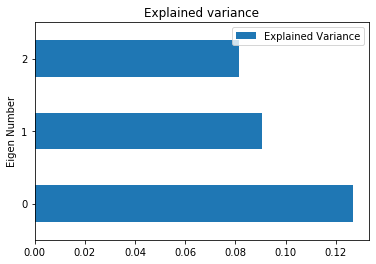

In [33]:
# Explained variance

data_dict = {
    'Explained Variance' : list(pca.explained_variance_ratio_[:3]),
    'Eigen Number' : list(range(3))
}
df = pd.DataFrame(data_dict)
df.plot.barh(title = "Explained variance", x = 'Eigen Number', y = 'Explained Variance')

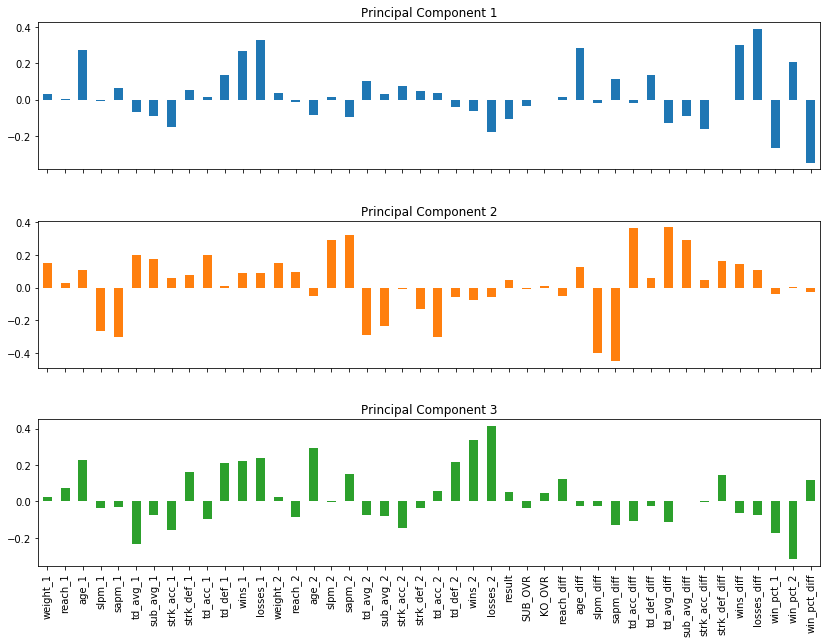

In [25]:
# Graphing top Eigenvectors
Num_Comps = 3
top_eigens = pd.DataFrame(weights[:Num_Comps], columns = data_scaled.columns)
top_eigens.index = [f'Principal Component {i}' for i in range(1, Num_Comps + 1)]

axes = top_eigens.T.plot.bar(subplots = True, legend = False, figsize = (14, 10))
plt.subplots_adjust(hspace = 0.35)

### Using as Model Input

In [46]:
# Scaling data

scaler = StandardScaler()
# scaler = RobustScaler() -- performs worse
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Transforming training data using PCA

x_train = PCA(n_components = None).fit_transform(x_train)

# Creating parameter grid

c = [0.001, 0.01, 0.1, 1, 10, 100]
# penalty = [None, 'l2', 'l1', 'elasticnet'] -- Some penalties can only be used with some solvers. Look at how to
                                                # implement more involved parameter grid 
param_grid = {
    'C' : c
}

# Running ML function
lr = grid_search_classifier(LogisticRegression(random_state = 0, max_iter = 500), param_grid)

Best parameters are: {'C': 0.001}

Accuracy is: 0.41935483870967744

AUC score is: 0.6220322886989553

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.42      1.00      0.59        39
Higher Ranked       0.00      0.00      0.00        54

     accuracy                           0.42        93
    macro avg       0.21      0.50      0.30        93
 weighted avg       0.18      0.42      0.25        93



/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LDA

# Testing Bet Constructs

### Data setup

In [38]:
# Importing
data = pd.read_csv('mma_data_odds.csv', index_col = 0)

# Engineering some columns
data['reach_diff'] = data.reach_1 - data.reach_2
data['age_diff'] = data.age_1 - data.age_2
data['slpm_diff'] = data.slpm_1 - data.slpm_2
data['sapm_diff'] = data.sapm_1 - data.sapm_2
data['td_acc_diff'] = data.td_acc_1 - data.td_acc_2
data['td_def_diff'] = data.td_def_1 - data.td_def_2
data['td_avg_diff'] = data.td_avg_1 - data.td_avg_2
data['sub_avg_diff'] = data.sub_avg_1 - data.sub_avg_2
data['strk_acc_diff'] = data.strk_acc_1 - data.strk_acc_2
data['strk_def_diff'] = data.strk_def_1 - data.strk_def_2
data['wins_diff'] = data.wins_1 - data.wins_2
data['losses_diff'] = data.losses_1 - data.losses_2
data['win_pct_1'] = data.wins_1/(data.losses_1 + data.wins_1)
data['win_pct_2'] = data.wins_2/(data.losses_2 + data.wins_2)
data['win_pct_diff'] = data.win_pct_1 - data.win_pct_2

# Splitting data
data_train = data.sample(frac = 0.75)
data_test = data.drop(data_train.index)

# Droping unecessary columnns and scaling data
x_cols = ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1', 'age_1']
y_col = ['result']
x_train, y_train = data_train[x_cols], data_train[y_col]
x_test, y_test = data_test[x_cols], data_test[y_col]

# Formatting data
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Random Forest Testing

In [39]:
# Training RF model

# Creating parameter grid
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 13)]
max_features = [int(x) for x in np.linspace(start = 3, stop = 10, num = 8)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth
}

# Running ML function
rf = grid_search_classifier(RandomForestClassifier(random_state = 0), param_grid)

Best parameters are: {'max_depth': 5, 'max_features': 4, 'n_estimators': 11}

Accuracy is: 0.5826086956521739

AUC score is: 0.6430303030303031

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.65      0.27      0.38        55
Higher Ranked       0.57      0.87      0.68        60

     accuracy                           0.58       115
    macro avg       0.61      0.57      0.53       115
 weighted avg       0.61      0.58      0.54       115



In [40]:
# Putting model predictions into the data

data_test['Prediction_rf'] = rf.predict(x_test)

In [41]:
# Function to create bet size
# def rf_bets(row):
#     if row.Prediction_rf == 1:
#         if (row.Fighter_1_Odds > 100) & (row.Fighter_1_Odds < 150):
#             bet = 100
#         elif (row.Fighter_1_Odds >= 150) & (row.Fighter_1_Odds < 200):
#             bet = 250
#         elif (row.Fighter_1_Odds >= 200):
#             bet = 500
#         elif (row.Fighter_1_Odds <= 100) & (row.Fighter_1_Odds > -150):
#             bet = 75
#         elif (row.Fighter_1_Odds <= -150) & (row.Fighter_1_Odds > -200):
#             bet = 50
#         elif (row.Fighter_1_Odds <= -200):
#             bet = 25
#         else:
#             bet = 0
#     if row.Prediction_rf == 0:
#         if (row.Fighter_2_Odds > 100) & (row.Fighter_2_Odds < 150):
#             bet = 100
#         elif (row.Fighter_2_Odds >= 150) & (row.Fighter_2_Odds < 200):
#             bet = 250
#         elif (row.Fighter_2_Odds >= 200):
#             bet = 500
#         elif (row.Fighter_2_Odds <= 100) & (row.Fighter_2_Odds > -150):
#             bet = 75
#         elif (row.Fighter_2_Odds <= -150) & (row.Fighter_2_Odds > -200):
#             bet = 50
#         elif (row.Fighter_2_Odds <= -200):
#             bet = 25
#         else:
#             bet = 0
#     return bet

def rf_bets(row):
    if row.Prediction_rf == 1:
        if (row.Fighter_1_Odds > 100) & (row.Fighter_1_Odds <= 200):
            bet = 50
        elif (row.Fighter_1_Odds > 200):
            bet = 25
        elif (row.Fighter_1_Odds <= 100) & (row.Fighter_1_Odds >= -200):
            bet = 75
        elif (row.Fighter_1_Odds < -200):
            bet = 100
        else:
            bet = 0
    if row.Prediction_rf == 0:
        if (row.Fighter_2_Odds > 100) & (row.Fighter_2_Odds <= 200):
            bet = 50
        elif (row.Fighter_2_Odds > 200):
            bet = 25
        elif (row.Fighter_2_Odds <= 100) & (row.Fighter_2_Odds >= -200):
            bet = 75
        elif (row.Fighter_2_Odds < -200):
            bet = 100
        else:
            bet = 0
    return bet

def calculate_payoff_and_result(row):
    # Calculating Payoff
    if row.Prediction_rf == 1:
        if row.Fighter_1_Odds>0:
            payoff = (row.Fighter_1_Odds/100)*row.Bet
        else:
            payoff = row.Bet/((abs(row.Fighter_1_Odds)/100))
    else:
        if row.Fighter_2_Odds>0:
            payoff = (row.Fighter_2_Odds/100)*row.Bet
        else:
            payoff = row.Bet/((abs(row.Fighter_2_Odds)/100))
    # Calculating Bet Result
    if row.Prediction_rf == row.result:
        bet_result = payoff
    else:
        bet_result = -(row.Bet)
    
    return bet_result
            
data_rf = data_test[['fighter_1', 'fighter_2', 'Fighter_1_Odds', 'Fighter_2_Odds', 'Prediction_rf', 'result']].reset_index(drop = True)
data_rf['Bet'] = data_rf.apply(rf_bets, axis = 1)
# data_rf['Bet'] = 100
data_rf['Bet_Result'] = data_rf.apply(calculate_payoff_and_result, axis = 1)

data_rf.Bet_Result.sum()

48.06894362749002

### SVM Testing

In [4]:
# Training SVM model

# Creating parameter grid

kernel = ['rbf', 'poly', 'sigmoid']
degree = [int(x) for x in np.linspace(start = 2, stop = 7, num = 5)]
c = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {
    'C' : c,
    'kernel' : kernel,
    'degree' : degree
}

# Running ML function
svm = grid_search_classifier(SVC(random_state = 0), param_grid)

Best parameters are: {'C': 100, 'degree': 2, 'kernel': 'sigmoid'}

Accuracy is: 0.4956521739130435

Classification report:
                precision    recall  f1-score   support

 Lower Ranked       0.38      0.39      0.38        46
Higher Ranked       0.58      0.57      0.57        69

     accuracy                           0.50       115
    macro avg       0.48      0.48      0.48       115
 weighted avg       0.50      0.50      0.50       115



In [5]:
# Putting model predictions into the data

data_test['Prediction_rf'] = rf.predict(x_test)

In [12]:
# Function to create bet size
# def rf_bets(row):
#     if row.Prediction_rf == 1:
#         if (row.Fighter_1_Odds > 100) & (row.Fighter_1_Odds < 150):
#             bet = 100
#         elif (row.Fighter_1_Odds >= 150) & (row.Fighter_1_Odds < 200):
#             bet = 250
#         elif (row.Fighter_1_Odds >= 200):
#             bet = 500
#         elif (row.Fighter_1_Odds <= 100) & (row.Fighter_1_Odds > -150):
#             bet = 75
#         elif (row.Fighter_1_Odds <= -150) & (row.Fighter_1_Odds > -200):
#             bet = 50
#         elif (row.Fighter_1_Odds <= -200):
#             bet = 25
#         else:
#             bet = 0
#     if row.Prediction_rf == 0:
#         if (row.Fighter_2_Odds > 100) & (row.Fighter_2_Odds < 150):
#             bet = 100
#         elif (row.Fighter_2_Odds >= 150) & (row.Fighter_2_Odds < 200):
#             bet = 250
#         elif (row.Fighter_2_Odds >= 200):
#             bet = 500
#         elif (row.Fighter_2_Odds <= 100) & (row.Fighter_2_Odds > -150):
#             bet = 75
#         elif (row.Fighter_2_Odds <= -150) & (row.Fighter_2_Odds > -200):
#             bet = 50
#         elif (row.Fighter_2_Odds <= -200):
#             bet = 25
#         else:
#             bet = 0
#     return bet

def rf_bets(row):
    if row.Prediction_rf == 1:
        if (row.Fighter_1_Odds > 100) & (row.Fighter_1_Odds <= 200):
            bet = 50
        elif (row.Fighter_1_Odds > 200):
            bet = 25
        elif (row.Fighter_1_Odds <= 100) & (row.Fighter_1_Odds >= -200):
            bet = 75
        elif (row.Fighter_1_Odds < -200):
            bet = 100
        else:
            bet = 0
    if row.Prediction_rf == 0:
        if (row.Fighter_2_Odds > 100) & (row.Fighter_2_Odds <= 200):
            bet = 50
        elif (row.Fighter_2_Odds > 200):
            bet = 25
        elif (row.Fighter_2_Odds <= 100) & (row.Fighter_2_Odds >= -200):
            bet = 75
        elif (row.Fighter_2_Odds < -200):
            bet = 100
        else:
            bet = 0
    return bet

def calculate_payoff_and_result(row):
    # Calculating Payoff
    if row.Prediction_rf == 1:
        if row.Fighter_1_Odds>0:
            payoff = (row.Fighter_1_Odds/100)*row.Bet
        else:
            payoff = row.Bet/((abs(row.Fighter_1_Odds)/100))
    else:
        if row.Fighter_2_Odds>0:
            payoff = (row.Fighter_2_Odds/100)*row.Bet
        else:
            payoff = row.Bet/((abs(row.Fighter_2_Odds)/100))
    # Calculating Bet Result
    if row.Prediction_rf == row.result:
        bet_result = payoff
    else:
        bet_result = -(row.Bet)
    
    return bet_result
            
data_rf = data_test[['fighter_1', 'fighter_2', 'Fighter_1_Odds', 'Fighter_2_Odds', 'Prediction_rf', 'result']].reset_index(drop = True)
data_rf['Bet'] = data_rf.apply(rf_bets, axis = 1)
# data_rf['Bet'] = 100
data_rf['Bet_Result'] = data_rf.apply(calculate_payoff_and_result, axis = 1)

data_rf.Bet_Result.sum()

31.553172675032567

# Reinforcement Learning

### Preparing data

In [7]:
# Importing
data = pd.read_csv('mma_data_odds.csv', index_col = 0)

# Engineering some columns
data['reach_diff'] = data.reach_1 - data.reach_2
data['age_diff'] = data.age_1 - data.age_2
data['slpm_diff'] = data.slpm_1 - data.slpm_2
data['sapm_diff'] = data.sapm_1 - data.sapm_2
data['td_acc_diff'] = data.td_acc_1 - data.td_acc_2
data['td_def_diff'] = data.td_def_1 - data.td_def_2
data['td_avg_diff'] = data.td_avg_1 - data.td_avg_2
data['sub_avg_diff'] = data.sub_avg_1 - data.sub_avg_2
data['strk_acc_diff'] = data.strk_acc_1 - data.strk_acc_2
data['strk_def_diff'] = data.strk_def_1 - data.strk_def_2
data['wins_diff'] = data.wins_1 - data.wins_2
data['losses_diff'] = data.losses_1 - data.losses_2
data['win_pct_1'] = data.wins_1/(data.losses_1 + data.wins_1)
data['win_pct_2'] = data.wins_2/(data.losses_2 + data.wins_2)
data['win_pct_diff'] = data.win_pct_1 - data.win_pct_2

# Droping unecessary columnns and scaling data
x_cols = ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1', 'age_1']
x_predict = data[x_cols]

# Formatting data
x_predict = x_predict.values

# Putting model predictions into the data

data['Prediction_1_lr'] = lr.predict_proba(x_predict)[:, 0]
data['Prediction_2_lr'] = 1.0 - data.Prediction_1_lr
data['Prediction_rf'] = rf.predict(x_predict)

data.dropna(inplace = True)
data = data[(data.Fighter_1_Odds != 0) & (data.Fighter_2_Odds != 0)]
data.reset_index(drop = True, inplace = True)

# Scaling
cols_rf = ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1', 'age_1', 'Prediction_1_lr', 'Prediction_rf']
scaler = StandardScaler()
data[cols_rf] = scaler.fit_transform(data[cols_rf])

### Creating gym environment

In [8]:
# Environment

class BettingEnv(gym.Env):
    
    def __init__(self, df, initial_funds):
        self.df = df
        self.current_step = 0
        self.initial_funds = initial_funds
        self.current_funds = initial_funds
        # Actions of the format Team 1 x%, Team 2 x%, No bet, etc.
        self.action_space = gym.spaces.Box(
          low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(17,), dtype=np.float32)
    
    def step(self, action):
        self.current_step += 1
        action_type = action[0]
        action_amount = (action[1] * self.current_funds) / 100.0
        
        if self.current_step >= len(self.df):
            done = True
            reward = 0
            obs = self.df.loc[len(self.df) - 1, ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1', 'age_1', 'Prediction_1_lr', 'Prediction_rf']].values
            
        else:
            done = False
            row = self.df.loc[self.current_step, :]
            obs = row[['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1', 'age_1', 'Prediction_1_lr', 'Prediction_rf']].values
            
            if action_type < 1:
                # Betting on fighter 1
                if row[['Fighter_1_Odds']].values[0] > 0:
                    payoff = (row[['Fighter_1_Odds']].values[0]/100)*action_amount
                else:
                    payoff = action_amount/((abs(row[['Fighter_1_Odds']].values[0])/100))
                # Determining reward based on result
                if row[['result']].values[0] == 1:
                    reward = payoff
                else:
                    reward = -(action_amount)
                
            elif action_type < 2:
                # Determining payoff (away team)
                if row[['Fighter_2_Odds']].values[0] > 0:
                    payoff = (row[['Fighter_2_Odds']].values[0]/100)*action_amount
                else:
                    payoff = action_amount/((abs(row[['Fighter_2_Odds']].values[0])/100))
                # Determining reward based on result
                if row[['result']].values[0] == 0:
                    reward = payoff
                else:
                    reward = -(action_amount)
                
            else:
                # No bet
                reward = 0

        self.current_funds += reward
        return obs, reward, done, {}
    
    def reset(self):
        self.current_step = 0
        self.current_funds = self.initial_funds
        return self.df.loc[self.current_step, ['reach_diff', 'age_diff', 'slpm_diff', 'sapm_diff', 'td_acc_diff', 'td_def_diff',
              'td_avg_diff', 'sub_avg_diff', 'strk_acc_diff', 'strk_def_diff', 'wins_diff',
              'losses_diff', 'win_pct_diff', 'weight_1', 'age_1', 'Prediction_1_lr', 'Prediction_rf']]
    
    def render(self, mode='human'):
        # Render the environment
        print(f"Current funds: {self.current_funds}")

### Trying different models

In [12]:
def train_and_test_rl(model):
    model.learn(total_timesteps=1000)

    for j in range(20):
        obs = env.reset()
        for i in range(len(data)):
            action, _states = model.predict(obs)
            obs, rewards, dones, info = env.step(action)
            if i == len(data) - 2:
                env.render()
    return model

env = DummyVecEnv([lambda: BettingEnv(data, 100000)])

/Users/hsinger24/Desktop/Programming/anaconda3/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [11]:
# PPO

train_and_test_rl(model = PPO('MlpPolicy', env, verbose=1))

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1141 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
Current funds: 88813.7542360559
Current funds: 90361.64622406459
Current funds: 83610.7187949886
Current funds: 83670.9989520488
Current funds: 101462.19764626469
Current funds: 96520.01009571136
Current funds: 78881.19072597213
Current funds: 98515.61738329068
Current funds: 91396.72358656225
Current funds: 103985.55985897621
Current funds: 116584.71229474928
Current funds: 89076.28036427201
Current funds: 94983.4483812725
Current funds: 81993.65471427032
Current funds: 89691.77936542897
Current funds: 86916.38000711292
Current funds: 85681.19087635347
Current funds: 86107.81666297912
Current funds: 76309.12672405827
Current funds: 87013.68610020656


In [13]:
# SAC

model = train_and_test_rl(model = SAC('MlpPolicy', env, verbose=1))

Using cpu device
Current funds: 105363.4275615228
Current funds: 112091.29000753284
Current funds: 109648.07200136056
Current funds: 107518.62222057713
Current funds: 102096.89457342675
Current funds: 109421.340786008
Current funds: 104083.59302854026
Current funds: 98814.87376929198
Current funds: 110518.44020069299
Current funds: 104717.09050556381
Current funds: 113090.8879021772
Current funds: 109494.55535236285
Current funds: 110339.537216061
Current funds: 113220.49653285477
Current funds: 108043.10654100274
Current funds: 107017.67181576364
Current funds: 110690.798055238
Current funds: 106178.65030494554
Current funds: 109193.20044603878
Current funds: 108306.29504158277


In [14]:
model.save('SAC_model')